Introduction and Setup

In previous lessons, we learned about vanills RNN, GRU, and LSTM networks. In this module, we'll use a really simple time series dataset to dig into the details of how each of these networks work. In the following few lessons, we will code each of these networks from scratch.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu:0'

Creating a Dataset

In this module, we want a simple dataset with 1 dimension that changes over time. We'll use a \(sin\) function and add a bit of noise to create this dataset. The first 4000 steps will be the training dataset, and the next 2000 steps will be the validation dataset.

In [3]:
TRAIN_STEPS = 4000
VALID_STEPS = TRAIN_STEPS // 2
X = torch.sin(torch.linspace(0, 25, TRAIN_STEPS + VALID_STEPS)) + torch.randn(TRAIN_STEPS + VALID_STEPS) * 0.3

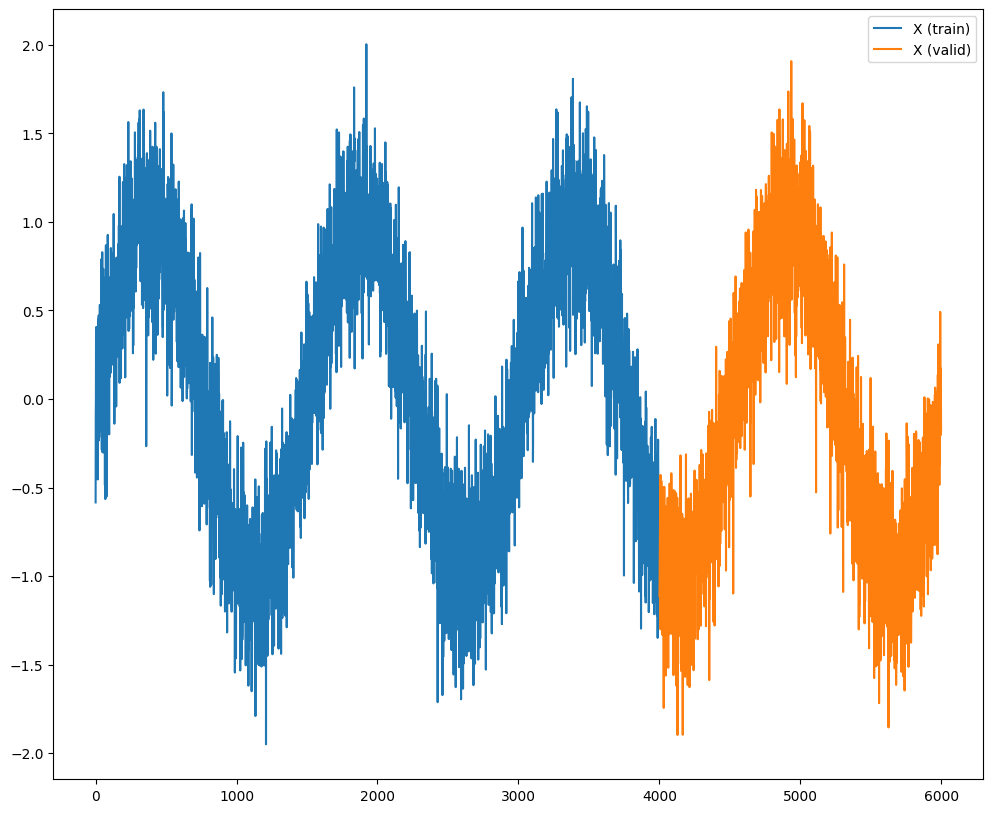

In [4]:
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(range(TRAIN_STEPS), X[:TRAIN_STEPS], alpha=1.0, label='X (train)')
ax.plot(range(TRAIN_STEPS, TRAIN_STEPS + VALID_STEPS), X[TRAIN_STEPS:], label='X (valid)')
ax.legend()

Now, let's split X into the train and validation sets.

In [5]:
x_train = X[:TRAIN_STEPS]
x_valid = X[TRAIN_STEPS:]

Create our Datasets and Dataloaders

In a time series problem, our goal is to predict the next step. If our goal is to predict the next time step based on 30 examples, our X will have 30 examples, and our Y will be our X shifted by 1 to include the next time step.
Let's create a Dataset that implements this logic.

NOTE: RNNs expect data with 3 dimensions: batch_size, n_steps, n_features. When we shift from modeling a 1-d array to modeling text, we'll see that each word is represnted with a vector of length n_features. In our case, n_features is 1, which is why we have a rank-2 tensor that we unsqueeze into a rank-3 tensor in the TimeSeriesDataset.

In [6]:
N_STEPS_BACK = 30

In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, series, n_steps):
        super().__init__()
        # store the time series
        self.series = series
        # store the number of steps back we go
        self.n_steps = n_steps

    def __len__(self):
        # The number of items we have here is the length of the
        # series - the number of steps - 1.
        # The 1 comes from the way we shift our X to create our y.
        return len(self.series) - self.n_steps - 1
    def __getitem__(self, idx):
        # Our X is the window of values ranging from idx to idx + self.n_steps
        # We unsqueeze here to create a `n_features` dimension.
        X = self.series[idx:idx+self.n_steps].unsqueeze(-1)
        # Our Y is X shifted by 1 in the future.
        Y = self.series[idx + 1:idx+self.n_steps + 1].unsqueeze(-1)
        return X, Y

In [8]:
ts_train = TimeSeriesDataset(x_train, N_STEPS_BACK)
ts_valid = TimeSeriesDataset(x_valid, N_STEPS_BACK)

Now that we've created our training and validation timeseries datasets, let's take a look at a single item. In the cell below, note that there are 30 time steps in one item of the dataset, and that y is x shifted one step into the future. This way, at every time step, the RNNs we build will try to predict the value at the next time step.

In [9]:
x, y = ts_train[0]
x.squeeze(), y.squeeze()

(tensor([-0.5842, -0.0893, -0.0027,  0.4010, -0.1040,  0.4067, -0.2321,  0.1194,
          0.0155, -0.3355,  0.1257, -0.0161, -0.1600, -0.3579, -0.3288, -0.4545,
          0.0475,  0.0644,  0.4179,  0.4499, -0.2186, -0.0458,  0.4718, -0.2337,
          0.0146, -0.2163,  0.3371, -0.1451, -0.0996,  0.0922]),
 tensor([-0.0893, -0.0027,  0.4010, -0.1040,  0.4067, -0.2321,  0.1194,  0.0155,
         -0.3355,  0.1257, -0.0161, -0.1600, -0.3579, -0.3288, -0.4545,  0.0475,
          0.0644,  0.4179,  0.4499, -0.2186, -0.0458,  0.4718, -0.2337,  0.0146,
         -0.2163,  0.3371, -0.1451, -0.0996,  0.0922,  0.5312]))

Finally, let's create our train and validatoin DataLoaders.

In [10]:
train_dl = DataLoader(ts_train, batch_size=8, shuffle=True)
valid_dl = DataLoader(ts_valid, batch_size=8, shuffle=False)

Let's implement this in an nn.Module. Instead of assigning our weights matrices, let's just use nn.Linear.

NOTE: Notice that in the RNNCell definition, the nn.Linear layers for the hidden state and inputs are different sizes. The hidden state will be the same shape as the outputs of the layer. If we assume the hidden state is the same shape as the inputs, our network will fail at the second time step.

In [11]:
class RNNCell(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        # W_hh_t-1
        self.h = nn.Linear(n_outputs, n_outputs)
        # W_xx_t
        self.x = nn.Linear(n_inputs, n_outputs)

    def forward(self, input, hidden):
        return torch.tanh(self.h(hidden) + self.x(input))

Let's test out this layer. Since our data is 1-dimensional, let's just represent it with 1 input and 1 output. To do this, we'll fetch a batch of data; isolate the inputs, which are the first time step for that batch of data; and create an initial state, which is a tensor of zeros of shape (batch_size, output_dim). We'll then pass the input and initial hidden state tensors through our simple RNN. The outputs will be the hidden state for the next time step.

In [12]:
r = RNNCell(1, 1)

In [13]:
# Fetch a batch of data
x, y = next(iter(train_dl))
# Get the first time step for the batch
inputs = x[:, 0, :]
# Create a hidden state that's of shape batch_size x output_dim
hidden = torch.zeros(inputs.shape[0], 1)

In [14]:
inputs

tensor([[-1.2092],
        [ 1.1806],
        [-0.0438],
        [ 0.7805],
        [ 0.4817],
        [-0.4032],
        [ 0.9688],
        [ 1.3240]])

In [15]:
hidden

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

Let's pass our inputs and initial hidden state to our RNN cell.

In [16]:
outputs = r(inputs, hidden)

In [17]:
outputs

tensor([[-0.9001],
        [-0.6037],
        [-0.7988],
        [-0.6797],
        [-0.7284],
        [-0.8372],
        [-0.6455],
        [-0.5734]], grad_fn=<TanhBackward0>)

Up until now, we've passed the first time step of our batch through our RNN cell. But what about the rest of the time steps? Let's create another module that turns our cell into a true RNN. We need another module to wrap RNNCell. It needs to do the following things:

Initialize a hidden state
For each time step, pass the inputs to a RNNCell, recording each output and updating the hidden state
Return the outputs and final hidden state
The code for this is given below:

In [18]:
class RNN(nn.Module):
    def __init__(self, n_inputs, n_outputs, cell):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.cell = cell(n_inputs, n_outputs)

    def forward(self, inputs):
        outputs = []
        # Initialize the hidden state as a tensor of zeros
        hidden_state = torch.zeros(inputs.shape[0], self.n_outputs).to(DEVICE)
        n_steps = inputs.shape[1]
        # For each time step...
        for i in range(n_steps):
            # The hidden state is now the outputs of the x_t and h_t-1
            hidden_state = self.cell(inputs[:, i], hidden_state)
            # Store the hidden state
            outputs.append(hidden_state)

        # Return a tensor of the historical outputs and the final hidden state
        return torch.stack(outputs, dim=1), hidden_state

Finally, let's train our RNN. Just to compare with torch's implementation, we'll also come back and train an nn.RNN. We'll see the outputs are slightly different since nn.RNN can stack multiple RNN layers, while ours just implements a single layer. As we train both models, we'll see that they both converge on the about the same loss. The initial loss is different because the torch RNN initializes its parameters differently than we do.

First, let's instantiate our RNN model, and a torch RNN.

In [19]:
our_model = RNN(1, 1, RNNCell).to(DEVICE)
torch_model = nn.RNN(input_size=1, hidden_size=1, num_layers=1, batch_first=True).to(DEVICE)

What happens when we pass a batch of data through each model? Are the shapes of the outputs the same?

In [20]:
seq, state = our_model(x.to(DEVICE))
seq.shape, state.shape

(torch.Size([8, 30, 1]), torch.Size([8, 1]))

In [21]:
seq, state = torch_model(x.to(DEVICE))
seq.shape, state.shape

(torch.Size([8, 30, 1]), torch.Size([1, 8, 1]))

Next, let's create our optimizers. We'll create one for the torch model, and one for the one we created.

In [22]:
our_opt = optim.Adam(our_model.parameters())
torch_opt = optim.Adam(torch_model.parameters())

Finally, let's train our RNN.

In [23]:
N_EPOCHS = 10
for i in range(N_EPOCHS):
    # train loop
    our_epoch_loss = 0.
    torch_epoch_loss = 0.
    n_batches = 0
    our_model.train()
    torch_model.train()
    for x, y in train_dl:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        seq, state = our_model(x)
        loss = F.mse_loss(seq, y)
        our_epoch_loss += loss.item()

        loss.backward()
        our_opt.step()
        our_opt.zero_grad()

        seq, state = torch_model(x)
        loss = F.mse_loss(seq, y)
        torch_epoch_loss += loss.item()

        loss.backward()
        torch_opt.step()
        torch_opt.zero_grad()

        n_batches += 1

    our_train_loss = our_epoch_loss/n_batches
    torch_train_loss = torch_epoch_loss/n_batches

    # valid loop
    our_epoch_loss = 0.
    torch_epoch_loss = 0.
    n_batches = 0
    our_model.eval()
    torch_model.eval()
    for x, y in valid_dl:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        with torch.no_grad():
            seq, state = our_model(x)
        loss = F.mse_loss(seq, y)
        our_epoch_loss += loss.item()

        with torch.no_grad():
            seq, state = torch_model(x)
        loss = F.mse_loss(seq, y)
        torch_epoch_loss += loss.item()

        torch_opt.step()
        torch_opt.zero_grad()

        n_batches += 1

    our_valid_loss = our_epoch_loss/n_batches
    torch_valid_loss = torch_epoch_loss/n_batches


    print(f"Epoch: {i}, Our train MSE: {our_epoch_loss/n_batches:.05f}, Torch train MSE: {torch_epoch_loss/n_batches:.05f}, Our valid MSE: {our_valid_loss/n_batches:.05f}, Torch valid MSE: {torch_valid_loss/n_batches:.05f}")


Epoch: 0, Our train MSE: 0.24669, Torch train MSE: 0.67920, Our valid MSE: 0.00100, Torch valid MSE: 0.00275
Epoch: 1, Our train MSE: 0.13680, Torch train MSE: 0.40509, Our valid MSE: 0.00055, Torch valid MSE: 0.00164
Epoch: 2, Our train MSE: 0.12667, Torch train MSE: 0.15127, Our valid MSE: 0.00051, Torch valid MSE: 0.00061
Epoch: 3, Our train MSE: 0.12605, Torch train MSE: 0.12684, Our valid MSE: 0.00051, Torch valid MSE: 0.00051
Epoch: 4, Our train MSE: 0.12595, Torch train MSE: 0.12607, Our valid MSE: 0.00051, Torch valid MSE: 0.00051
Epoch: 5, Our train MSE: 0.12588, Torch train MSE: 0.12594, Our valid MSE: 0.00051, Torch valid MSE: 0.00051
Epoch: 6, Our train MSE: 0.12626, Torch train MSE: 0.12626, Our valid MSE: 0.00051, Torch valid MSE: 0.00051
Epoch: 7, Our train MSE: 0.12610, Torch train MSE: 0.12610, Our valid MSE: 0.00051, Torch valid MSE: 0.00051
Epoch: 8, Our train MSE: 0.12596, Torch train MSE: 0.12594, Our valid MSE: 0.00051, Torch valid MSE: 0.00051
Epoch: 9, Our train

While it's fun and educational to implement these things from scratch, it's often better to use torch's implementation. We'll illustrate this by timing the processing of one batch. We notice that torch's RNN is much faster than ours.

In [24]:
x, y = next(iter(train_dl))
x = x.to(DEVICE)
y = y.to(DEVICE)

In [25]:
%%timeit
our_model(x)

4.28 ms ± 770 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%%timeit
torch_model(x)

191 µs ± 4.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Let's implement one ourselves. We'll see that even though the math looks confusing, it's only a few lines of code. Try to look at the implementation and see which equation each nn.Linear module maps to.

NOTE: When we implemented our simple RNN cell, we had separate weights matrices for the input and hidden state. In this implementation of a GRU cell, we will just use 1 weights matrix but concatenate the inputs and state.

In [27]:
class OurGRUCell(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        # Combine Wxr and Whr
        self.R = nn.Linear(in_dim + out_dim, out_dim)
        # Combine Wxz and Whz
        self.Z = nn.Linear(in_dim + out_dim, out_dim)
        # Combine Whx and Whz
        self.H = nn.Linear(in_dim + out_dim, out_dim)

    def forward(self, inputs, hidden_state):
        xh = torch.cat((inputs, hidden_state), dim=-1)
        R = torch.sigmoid(self.R(xh))
        Z = torch.sigmoid(self.Z(xh))
        xrh = torch.cat((inputs, R * hidden_state), dim=-1)
        HC = torch.tanh(self.H(xrh))
        ht = Z * hidden_state + (1 - Z) * HC
        return ht


In [28]:
OUT_DIM = 3
gru = OurGRUCell(1, OUT_DIM)

In [29]:
x, y = next(iter(train_dl))

In [30]:
state = torch.zeros(x.shape[0], OUT_DIM)
timestep = x[:, 0, :]

In [31]:
gru(timestep, state)

tensor([[-0.0956,  0.0607, -0.0870],
        [-0.0837, -0.0680, -0.1353],
        [-0.0988,  0.0951, -0.0744],
        [-0.1249,  0.3339,  0.0173],
        [-0.0597, -0.3040, -0.2479],
        [-0.0883, -0.0173, -0.1158],
        [-0.1011,  0.1196, -0.0655],
        [-0.0688, -0.2219, -0.2024]], grad_fn=<AddBackward0>)

Finally, to train a GRU, we just need to create an nn.Module that passes each time step through the cell. We'll use the RNN class we built earlier.

In [32]:
our_model = RNN(1, 1, OurGRUCell).to(DEVICE)
torch_model = nn.GRU(input_size=1, hidden_size=1, num_layers=1, batch_first=True).to(DEVICE)

In [33]:
our_opt = optim.Adam(our_model.parameters())
torch_opt = optim.Adam(torch_model.parameters())

In [34]:
N_EPOCHS = 10
for i in range(N_EPOCHS):
    # train loop
    our_epoch_loss = 0.
    torch_epoch_loss = 0.
    n_batches = 0
    our_model.train()
    torch_model.train()
    for x, y in train_dl:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        seq, state = our_model(x)
        loss = F.mse_loss(seq, y)
        our_epoch_loss += loss.item()

        loss.backward()
        our_opt.step()
        our_opt.zero_grad()

        seq, state = torch_model(x)
        loss = F.mse_loss(seq, y)
        torch_epoch_loss += loss.item()

        loss.backward()
        torch_opt.step()
        torch_opt.zero_grad()

        n_batches += 1

    our_train_loss = our_epoch_loss/n_batches
    torch_train_loss = torch_epoch_loss/n_batches

    # valid loop
    our_epoch_loss = 0.
    torch_epoch_loss = 0.
    n_batches = 0
    our_model.eval()
    torch_model.eval()
    for x, y in valid_dl:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        with torch.no_grad():
            seq, state = our_model(x)
        loss = F.mse_loss(seq, y)
        our_epoch_loss += loss.item()

        with torch.no_grad():
            seq, state = torch_model(x)
        loss = F.mse_loss(seq, y)
        torch_epoch_loss += loss.item()

        torch_opt.step()
        torch_opt.zero_grad()

        n_batches += 1

    our_valid_loss = our_epoch_loss/n_batches
    torch_valid_loss = torch_epoch_loss/n_batches


    print(f"Epoch: {i}, Our train MSE: {our_epoch_loss/n_batches:.05f}, Torch train MSE: {torch_epoch_loss/n_batches:.05f}, Our valid MSE: {our_valid_loss/n_batches:.05f}, Torch valid MSE: {torch_valid_loss/n_batches:.05f}")


Epoch: 0, Our train MSE: 0.67450, Torch train MSE: 0.22623, Our valid MSE: 0.00273, Torch valid MSE: 0.00092
Epoch: 1, Our train MSE: 0.39135, Torch train MSE: 0.14223, Our valid MSE: 0.00158, Torch valid MSE: 0.00058
Epoch: 2, Our train MSE: 0.19849, Torch train MSE: 0.12627, Our valid MSE: 0.00080, Torch valid MSE: 0.00051
Epoch: 3, Our train MSE: 0.13690, Torch train MSE: 0.12426, Our valid MSE: 0.00055, Torch valid MSE: 0.00050
Epoch: 4, Our train MSE: 0.12384, Torch train MSE: 0.12408, Our valid MSE: 0.00050, Torch valid MSE: 0.00050
Epoch: 5, Our train MSE: 0.12263, Torch train MSE: 0.12398, Our valid MSE: 0.00050, Torch valid MSE: 0.00050
Epoch: 6, Our train MSE: 0.12270, Torch train MSE: 0.12394, Our valid MSE: 0.00050, Torch valid MSE: 0.00050
Epoch: 7, Our train MSE: 0.12263, Torch train MSE: 0.12380, Our valid MSE: 0.00050, Torch valid MSE: 0.00050
Epoch: 8, Our train MSE: 0.12265, Torch train MSE: 0.12374, Our valid MSE: 0.00050, Torch valid MSE: 0.00050
Epoch: 9, Our train

The code for an LSTM is given in the cell below:

In [35]:
def linear_with_act(n_inputs, n_outputs, act):
    return nn.Sequential(nn.Linear(n_inputs, n_outputs), act())

class OurLSTMCell(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        # Input, Forget, and Output gates
        self.I = linear_with_act(n_inputs + n_outputs, n_outputs, nn.Sigmoid)
        self.F = linear_with_act(n_inputs + n_outputs, n_outputs, nn.Sigmoid)
        self.O = linear_with_act(n_inputs + n_outputs, n_outputs, nn.Sigmoid)

        # Candidate memory cell
        self.HC = linear_with_act(n_inputs + n_outputs, n_outputs, nn.Tanh)


    def forward(self, inputs, hidden_state, memory_cell):
        xh = torch.cat((inputs, hidden_state), dim=-1)
        xc = torch.cat((inputs, memory_cell), dim=-1)
        I = self.I(xh)
        F = self.F(xh)
        O = self.O(xh)
        Cth = self.HC(xc)
        Ct = F * memory_cell + I * Cth
        Ht = O * torch.tanh(Ct)

        return Ht, Ct

Now let's observe the inputs and outputs for an LSTM cell by creating one and passing the first time step from a batch of data.

In [36]:
# create the LSTM cell
OUT_DIM = 3
lstm = OurLSTMCell(1, OUT_DIM)

In [37]:
# grab one batch of data
x, y = next(iter(train_dl))

In [38]:
state = torch.zeros(x.shape[0], OUT_DIM) # instantiate the initial hidden state
memory = torch.zeros_like(state) # instantiate the memory
timestep = x[:, 0, :] # isolate the first time step in the batch

In [39]:
# pass the timestep, initial state, and initial memory through the LSTM cell
# to obtain the hidden state and memory
H, C = lstm(timestep, state, memory)

Let's observe H and C. Since we specified 3 output features, we expect a tensor of batch size x 3 for our first time step as our state and memory outputs.

In [40]:
H

tensor([[-0.0295, -0.0303,  0.0114],
        [-0.0827, -0.0611,  0.1240],
        [-0.0483, -0.0541,  0.0519],
        [-0.0889, -0.0594,  0.1364],
        [-0.0413, -0.0476,  0.0368],
        [-0.0036,  0.0502, -0.0409],
        [-0.0619, -0.0610,  0.0811],
        [-0.0123,  0.0147, -0.0243]], grad_fn=<MulBackward0>)

In [41]:
C

tensor([[-0.0513, -0.0648,  0.0259],
        [-0.1707, -0.1849,  0.2951],
        [-0.0890, -0.1303,  0.1190],
        [-0.1878, -0.1881,  0.3275],
        [-0.0745, -0.1096,  0.0839],
        [-0.0057,  0.0912, -0.0916],
        [-0.1190, -0.1603,  0.1881],
        [-0.0202,  0.0283, -0.0545]], grad_fn=<AddBackward0>)

Next, we need to add the recurrent part to our LSTM. However, we can't use the same RNN class since that class does not implement the memory cell. Instead, we'll use the similar class below. Note that in this class, we don't return the memory - the torch implementation does return the memory for each LSTM layer.

In [42]:
class LSTM(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.cell = OurLSTMCell(n_inputs, n_outputs)

    def forward(self, inputs):
        outputs = []
        # Initialize the hidden state and memory as a tensor of zeros
        hidden_state = torch.zeros(inputs.shape[0], self.n_outputs).to(DEVICE)
        memory = torch.zeros_like(hidden_state)
        n_steps = inputs.shape[1]
        # For each time step...
        for i in range(n_steps):
            # The hidden state is now the outputs of the x_t and h_t-1
            hidden_state, memory = self.cell(inputs[:, i], hidden_state, memory)
            # Store the hidden state
            outputs.append(hidden_state)

        # Return a tensor of the historical outputs and the final hidden state
        return torch.stack(outputs, dim=1), hidden_state

In the cells below, we instantiate our implementation of the LSTM and torch's. We also create optimizers for each model.

In [43]:
our_model = LSTM(1, 1).to(DEVICE)
torch_model = nn.LSTM(input_size=1, hidden_size=1, num_layers=1, batch_first=True).to(DEVICE)

In [44]:
our_opt = optim.Adam(our_model.parameters())
torch_opt = optim.Adam(torch_model.parameters())

In the cell below, we run our own training loop for our LSTM models.

In [45]:
N_EPOCHS = 10
for i in range(N_EPOCHS):
    # train loop
    our_epoch_loss = 0.
    torch_epoch_loss = 0.
    n_batches = 0
    our_model.train()
    torch_model.train()
    for x, y in train_dl:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        seq, state = our_model(x)
        loss = F.mse_loss(seq, y)
        our_epoch_loss += loss.item()

        loss.backward()
        our_opt.step()
        our_opt.zero_grad()

        seq, (state, memory) = torch_model(x)
        loss = F.mse_loss(seq, y)
        torch_epoch_loss += loss.item()

        loss.backward()
        torch_opt.step()
        torch_opt.zero_grad()

        n_batches += 1

    our_train_loss = our_epoch_loss/n_batches
    torch_train_loss = torch_epoch_loss/n_batches

    # valid loop
    our_epoch_loss = 0.
    torch_epoch_loss = 0.
    n_batches = 0
    our_model.eval()
    torch_model.eval()
    for x, y in valid_dl:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        with torch.no_grad():
            seq, state = our_model(x)
        loss = F.mse_loss(seq, y)
        our_epoch_loss += loss.item()

        with torch.no_grad():
            seq, (state, memory) = torch_model(x)
        loss = F.mse_loss(seq, y)
        torch_epoch_loss += loss.item()

        torch_opt.step()
        torch_opt.zero_grad()

        n_batches += 1

    our_valid_loss = our_epoch_loss/n_batches
    torch_valid_loss = torch_epoch_loss/n_batches


    print(f"Epoch: {i}, Our train MSE: {our_epoch_loss/n_batches:.05f}, Torch train MSE: {torch_epoch_loss/n_batches:.05f}, Our valid MSE: {our_valid_loss/n_batches:.05f}, Torch valid MSE: {torch_valid_loss/n_batches:.05f}")


Epoch: 0, Our train MSE: 0.43210, Torch train MSE: 0.23528, Our valid MSE: 0.00175, Torch valid MSE: 0.00095
Epoch: 1, Our train MSE: 0.32905, Torch train MSE: 0.18168, Our valid MSE: 0.00133, Torch valid MSE: 0.00074
Epoch: 2, Our train MSE: 0.26248, Torch train MSE: 0.16109, Our valid MSE: 0.00106, Torch valid MSE: 0.00065
Epoch: 3, Our train MSE: 0.17586, Torch train MSE: 0.14785, Our valid MSE: 0.00071, Torch valid MSE: 0.00060
Epoch: 4, Our train MSE: 0.14623, Torch train MSE: 0.13811, Our valid MSE: 0.00059, Torch valid MSE: 0.00056
Epoch: 5, Our train MSE: 0.13616, Torch train MSE: 0.13099, Our valid MSE: 0.00055, Torch valid MSE: 0.00053
Epoch: 6, Our train MSE: 0.13120, Torch train MSE: 0.12631, Our valid MSE: 0.00053, Torch valid MSE: 0.00051
Epoch: 7, Our train MSE: 0.12836, Torch train MSE: 0.12339, Our valid MSE: 0.00052, Torch valid MSE: 0.00050
Epoch: 8, Our train MSE: 0.12636, Torch train MSE: 0.12137, Our valid MSE: 0.00051, Torch valid MSE: 0.00049
Epoch: 9, Our train